In [3]:
import argparse
import numpy as np
import torch
import torch.nn as nn

import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
plt.rcParams['savefig.dpi'] = 300

import sys
sys.path.append("..")
from utilities import *
from torch_symplectic_adjoint import odeint_symplectic_adjoint as odeint

# Damped pendulum
To illustrate that our method is well applicable to general ODE systems, we consider the pendulum problem, which has the form of $\dot x(t)=F(x(t))$. Specifically,
\begin{align*}
&\dot x_1 = x_2,\\
&\dot x_2 = -0.2 x_2-8.91 \sin(x_1).
\end{align*}
Here $x_1$ is the angular displacement, and $x_2$ is the angular velocity. This is a damped system that obeys a dissipation law: 
$$
\frac{d}{dt}\bigg(\frac{x^2_2}{2} +8.91(1-\cos(x_1))\bigg) = -0.2 x^2_2 \leq 0.
$$
The critical point $(0,0)$ is a stable focus. The training data is collected from $1$ trajectory starting from $[-1,-1]$ within time interval $[0,5]$ and time step $\Delta t=0.05$. The neural network $G$ used to approximate $f$ has $1$ hidden layer of $100$ neurons.

In [9]:
def get_parser():
    parser = argparse.ArgumentParser('Nonlinear gradient flow')
    parser.add_argument('--model_true', type=str, choices=['LGF', 'NGF', 'Pendulum', 'Lorenz'], default='Pendulum')
    parser.add_argument('--model_ocn', type=str, choices=['OCN', 'OCN_GF'], default='OCN')
    parser.add_argument('--x0', nargs='+', type=float, default=[-1., -1.])
    parser.add_argument('--train_time', type=float, default=5)
    parser.add_argument('--step_size', type=int, default=0.05)
    parser.add_argument('--batch_size', type=int, default=2)
    parser.add_argument('--test_time', type=int, default=20)
    parser.add_argument('--hidden_layers', type=int, default=1)
    parser.add_argument('--hidden_neurons', type=int, default=100)
    return parser

In [10]:
parser = get_parser()
args = parser.parse_args("")
device = torch.device('cuda:' + str(args.gpu) if torch.cuda.is_available() else 'cpu')
ckpt = torch.load('checkpoint/pretrained/Pendulum-G1x100-T5.0-bs2', map_location=torch.device('cpu'))

In [11]:
model_true = eval(args.model_true)
model_ocn = eval(args.model_ocn)
test_y0 = initial_point(args, device)

trf = model_true()
ocn = model_ocn(args)
ocn.load_state_dict(ckpt['net'])

true_y_test, test_t = build_dataset(args, model_true=model_true, data_type='test', y0=test_y0, device=device)
pred_y_test = odeint(ocn, test_y0, test_t, method="dopri5")

test_tt = test_t.cpu().numpy()
true_test_yy = true_y_test.cpu().detach().numpy()
pred_test_yy = pred_y_test.cpu().detach().numpy()

# Training results
After finishing training, we generate a trajectory over $[0,20]$ to examine the relatively long-term prediction performance of OCN. We observe accurate fitting between the true trajectory and the trajectory generated by OCN, even on a time interval that is much longer than what is used for training.

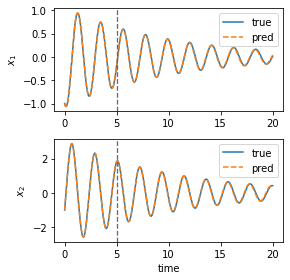

In [12]:
fig = plt.figure(figsize=(4, 4))

ax = fig.add_subplot(211)
ax.plot(test_tt, true_test_yy[:, 0, 0], '-', label=r'true')
ax.plot(test_tt, pred_test_yy[:, 0, 0], '--',label=r'pred')
ax.axvline(x=5, color='dimgrey', linewidth=1.3, linestyle='--')
plt.ylabel(r'$x_1$')
plt.legend(loc='upper right')

ax = fig.add_subplot(212)
ax.plot(test_tt, true_test_yy[:, 0, 1], '-', label=r'true')
ax.plot(test_tt, pred_test_yy[:, 0, 1], '--', label=r'pred')
ax.axvline(x=5, color='dimgrey', linewidth=1.3, linestyle='--')
plt.ylabel(r'$x_2$')
plt.xlabel("time")
plt.legend(loc='upper right')

plt.tight_layout()
#plt.savefig('plots/Pendulum_trajectory', dpi=300)

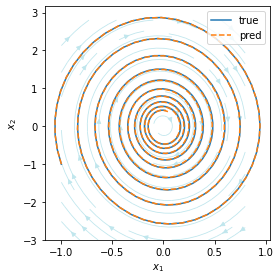

In [13]:
# 1D arrays
x = np.arange(-1,1,0.2)
y = np.arange(-3,3,0.2)
  
# Meshgrid
X,Y = np.meshgrid(x,y)
  
# Assign vector directions
Ex = Y
Ey = - 0.2*Y - 8.91*np.sin(X)
  
# Depict illustration
plt.figure(figsize=(4,4))
#plt.title('Vector field')
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.streamplot(X,Y,Ex,Ey, density=0.7, linewidth=0.8, color=(.75,.90,.93))
#plt.streamplot(X,Y,Ex,Ey, color='r', linewidth=2, start_points=[[-1,-1]], maxlength=2.5)

plt.plot(true_test_yy[:,0,0], true_test_yy[:,0,1], '-', color='C0', label='true')
plt.plot(pred_test_yy[:,0,0], pred_test_yy[:,0,1], '--', markersize=6, color='C1', label='pred')

# plt.plot(0, 0, 'r*', markersize=10)
# plt.plot(-1, -1, 'bo', markersize=7)

plt.legend(loc='upper right')
plt.tight_layout()
#plt.savefig('plots/Pendulum_phase', dpi=300)

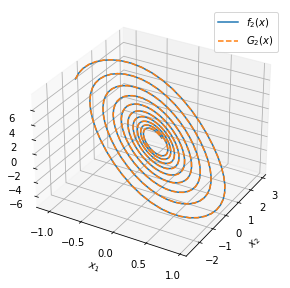

In [14]:
from mpl_toolkits import mplot3d

plt.figure(figsize=(4,4))
ax_func= plt.axes(projection='3d')
ax_func.zaxis._axinfo['juggled'] = (-2,-2,2)
#ax_func.set_title('Learned Function')
ax_func.set_xlabel(r'$x_1$')
ax_func.set_ylabel(r'$x_2$')
ax_func.plot3D(true_test_yy[:,0,0], true_test_yy[:,0,1], trf.F(true_y_test).detach().numpy()[:,0,1], color='C0', label=r'$f_2(x)$')
ax_func.plot3D(true_test_yy[:,0,0], true_test_yy[:,0,1], ocn.F(true_y_test).detach().numpy()[:,0,1], '--', color='C1', label=r'$G_2(x)$')
plt.legend()

plt.tight_layout()
#plt.savefig('plots/Pendulum_func', dpi=300)

This is a comparison between the true governing function $f(x)$ and the trained neural network $G(x,\cdot)$, where $x$ represents the training data set $\{x_i\}$. 